In [1]:
import os

In [2]:
os.getcwd()

'/home/llaszczuk/Documents/studia/magister/analiza_dyfuzji/ANDI-challenge'

In [3]:
import andi
import joblib
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dalex as dx
import sweetviz as sv

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

pd.options.plotting.backend = 'plotly'
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from configuration import RANDOM_STATE, CLASS_MAPPING

In [4]:
def custom_residual_function(model, X, y):
    probs = model.predict_proba(X)
    real_class_pred = probs.flatten()[[int(probs.shape[1]*i+val) for i, val in enumerate(y)]]
    return np.abs((1 - real_class_pred).astype('float64'))

def custom_predict(model, X):
    return model.predict_proba(X)

def custom_predict_normal(model, X):
    return model.predict(X)

def custom_predict_old(model, X):
    pred_class = np.argmax(model.predict_proba(X), axis=1)
    return pred_class.astype('float')

def loss_accuracy(y_real, y_pred):
    return 1 - accuracy_score(y_real, y_pred)

def loss_multiclass(y_real, y_proba):
    proba_real = np.array([el[y_real[i]] for i, el in enumerate(y_proba)])
    return np.mean(1 - proba_real)

def categorical_cross_entropy(y_real, y_proba):        
    return np.mean(-np.log(y_proba.flatten()[[int(y_proba.shape[1]*i+value) for i,value in enumerate(y_real)]]))



In [5]:
def save_image(image, image_path):
    image.write_image(image_path)

In [4]:
sklearn.__version__

'0.24.1'

In [6]:
# model = joblib.load('Models/model_patrycja_2d.sav')
model = joblib.load('Models/model_hanna_2d.sav')

In [7]:
model.n_features_in_, model.feature_importances_

(17,
 array([0.02307495, 0.10786011, 0.03399968, 0.04437482, 0.03598899,
        0.15146145, 0.11389879, 0.05213904, 0.04369468, 0.01530478,
        0.03849317, 0.03352035, 0.06104322, 0.09083133, 0.04292022,
        0.04269129, 0.06870312]))

In [8]:
X = pd.read_csv('Data/characteristics/characteristics_h.csv')
X = X.drop(['file', 'Alpha'], axis=1)
y, X = X['motion'], X.drop(['motion'], axis=1)

In [9]:
X

,D,alpha,alpha_n_1,alpha_n_2,alpha_n_3,fractal_dimension,mean_gaussianity,mean_squared_displacement_ratio,straightness,p-variation,max_excursion_normalised,vac_lag_1,p_var_1,p_var_2,p_var_3,p_var_4,p_var_5
0,0.110463,9.009425e-01,0.832623,1.116492,0.961212,4.563710,0.690184,0.010296,0.025818,3.0,0.392861,-0.163076,-0.655079,-0.254711,0.144908,0.529789,0.897238
1,1.736047,8.212060e-01,1.446654,1.262404,0.807550,4.355927,0.365749,0.027893,0.035658,2.0,0.710903,-2.675932,-0.687811,-0.378076,-0.073835,0.223915,0.515161
2,1.422234,2.689001e-01,1.358378,0.219515,0.040902,1.186576,26.538101,0.183998,0.568895,3.0,0.884815,-0.500723,-0.303995,-0.030136,0.110595,0.226721,0.326735
3,0.149254,1.389649e+00,1.208545,1.024303,0.983084,10.941899,0.354268,-0.020015,0.055644,6.0,0.059281,0.047221,-0.282582,0.515686,1.358237,2.226734,3.110361
4,3.061054,1.531205e+00,1.616146,1.527227,1.459099,5.823485,0.344974,-0.035999,0.207588,6.0,0.033152,0.123412,-0.340625,0.282426,0.887257,1.483056,2.070455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63020,0.040903,5.734127e-01,0.553258,0.795023,0.608724,2.583997,6.725408,0.025834,0.012923,0.0,1.242073,-0.358753,-0.879165,-0.551149,-0.259729,-0.204644,-0.235184
63021,0.011982,1.667414e-11,0.034123,0.000021,0.000000,4.331022,1.008222,0.082661,0.005369,0.0,1.884397,-0.668359,-0.991418,-0.982920,-0.962718,-0.935521,-0.908420
63022,0.927286,9.919806e-01,1.160644,0.939448,0.881354,5.674659,0.685782,0.000754,0.069783,4.0,0.101556,0.269492,-0.481904,0.061225,0.609967,1.152905,1.685609
63023,0.391548,7.990308e-01,0.926904,1.011127,0.868929,4.177487,0.921778,0.019652,0.027428,1.0,0.327652,-1.573376,-0.781614,-0.561763,-0.357101,-0.168716,0.001170


In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/6, random_state=RANDOM_STATE)

In [11]:
y_test.iloc[0]

1.0

In [12]:
feature_names = X.columns

## Plan:
1. Overall model performance, standard feature importance -- done
2. Permutation feature importance --> eli5, dalex -- done
3. SHAP feature importance;
4. Stratx;
5. Partial dependence profiles;

## 1. Overall model performance

In [37]:
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)

In [38]:
generated_data_hist = px.histogram(y)

In [40]:
save_image(generated_data_hist, os.path.join('Explanation', 'h', 'generated_data_hist.png'))

In [41]:
predicted_data_hist = px.histogram(y_pred)

In [42]:
save_image(predicted_data_hist, os.path.join('Explanation', 'h', 'predicted_data_hist.png'))

In [43]:
confusion_matrix(y_test, y_pred)

array([[ 835,  487,   57,    7,  712],
       [ 273, 1777,   20,    0,   50],
       [  53,   29, 1376,  179,  400],
       [  19,    0,  156, 1879,   52],
       [ 367,   44,  143,   11, 1579]])

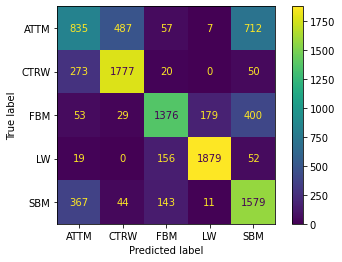

In [44]:
confusion_matrix_ = plot_confusion_matrix(model, x_test, y_test, display_labels=CLASS_MAPPING.values())

In [45]:
confusion_matrix_.figure_.savefig(os.path.join('Explanation', 'h', 'confusion_matrix.png'))
confusion_matrix_.figure_.savefig(os.path.join('Explanation', 'h', 'confusion_matrix.pdf'))

In [55]:
COMMON_ERRORS = {'True': ['ATTM', 'ATTM', 'FBM', 'SBM'],
                 'Predict': ['CTRW', 'SBM', 'CTRW', 'ATTM']}

In [57]:
# Most common errors
pd.DataFrame(COMMON_ERRORS)

,True,Predict
0,ATTM,CTRW
1,ATTM,SBM
2,FBM,CTRW
3,SBM,ATTM


In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.40      0.46      2098
         1.0       0.76      0.84      0.80      2120
         2.0       0.79      0.68      0.73      2037
         3.0       0.91      0.89      0.90      2106
         4.0       0.57      0.74      0.64      2144

    accuracy                           0.71     10505
   macro avg       0.71      0.71      0.70     10505
weighted avg       0.71      0.71      0.70     10505



## 2. Permutation feature importance with eli5

In [59]:
import eli5
from eli5.sklearn import PermutationImportance

In [60]:
model.feature_importances_

array([0.02307495, 0.10786011, 0.03399968, 0.04437482, 0.03598899,
       0.15146145, 0.11389879, 0.05213904, 0.04369468, 0.01530478,
       0.03849317, 0.03352035, 0.06104322, 0.09083133, 0.04292022,
       0.04269129, 0.06870312])

In [61]:
standard_fi_plot = px.bar(y=feature_names, x=model.feature_importances_)

In [62]:
save_image(standard_fi_plot, os.path.join('Explanation', 'h', 'standard_fi.png'))

### Basic permutation feature importance with eli5

In [34]:
perm = PermutationImportance(model).fit(x_test, y_test)

In [36]:
permutation_fi = eli5.show_weights(perm, feature_names=list(feature_names))

In [47]:
with open(os.path.join('Explanation', 'h','eli5-pfi.html'), 'w') as f:
    f.write(permutation_fi.data)


### Dalex explainer

In [13]:
explainer_proba = dx.Explainer(model, x_test, y_test, predict_function=custom_predict, residual_function=custom_residual_function)
explainer_normal = dx.Explainer(model, x_test, y_test, predict_function=custom_predict_normal, residual_function=custom_residual_function)

Preparation of a new explainer is initiated

  -> data              : 10505 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 10505 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x7f634c5a3d40> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.14e-10, mean = 0.2, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f634c5a7170>


/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning: 
  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)
  precalculate, verbose)


  -> residuals         : min = 1.43e-08, mean = 0.318, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 10505 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 10505 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f634c5ae0e0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.21, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f634c5a7170>
  -> residuals         : min = 1.43e-08, mean = 0.318, max = 1.0
  -> model_info        : package sklearn

A ne

In [14]:
pfi = explainer_proba.model_parts(loss_function=categorical_cross_entropy)

KeyboardInterrupt: 

In [65]:
pfi_categorical_cross_entropy = pfi.plot(max_vars=17, show=False)

In [66]:
save_image(pfi_categorical_cross_entropy, os.path.join('Explanation', 'h', 'pfi-logloss.png'))

### Categorical cross entropy loss function

In [67]:
pfi_categorical_cross_entropy

In [68]:
pfi_accuracy = explainer_normal.model_parts(loss_function=loss_accuracy)
pfi_accuracy_plot = pfi_accuracy.plot(max_vars=17, show=False)

In [69]:
save_image(pfi_accuracy_plot, os.path.join('Explanation', 'h', 'pfi-accuracy.png'))

### Accuracy loss function

In [70]:
pfi_accuracy_plot

### PFI per class

In [74]:
x_test['y'] = y_test
for i in range(5):    
    x_sub = x_test[x_test['y'] == i]
    y_sub, x_sub = x_sub['y'], x_sub.drop('y', axis=1)
    print(y_sub)
    
    explainer_sub = dx.Explainer(model, x_sub, y_sub, predict_function=custom_predict, residual_function=custom_residual_function)    
    pfi = explainer_sub.model_parts(loss_function=categorical_cross_entropy)
    pfi_plot = pfi.plot(max_vars=17, show=False)
    save_image(pfi_plot, os.path.join('Explanation', 'h', 'class_pfi', f"pfi-logloss-{CLASS_MAPPING[str(i)]}.pdf"))
    
    explainer_normal = dx.Explainer(model, x_sub, y_sub, predict_function=custom_predict_normal, residual_function=custom_residual_function)
    pfi = explainer_normal.model_parts(loss_function=loss_accuracy)
    pfi_plot = pfi.plot(max_vars=17, show=False)
    save_image(pfi_plot, os.path.join('Explanation', 'h', 'class_pfi', f"pfi-acc-{CLASS_MAPPING[str(i)]}.pdf"))

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



3955     0.0
884      0.0
5785     0.0
31507    0.0
54205    0.0
        ... 
49249    0.0
30371    0.0
59930    0.0
29343    0.0
53836    0.0
Name: y, Length: 2098, dtype: float64
Preparation of a new explainer is initiated

  -> data              : 2098 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2098 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x7f12f9cee4d0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 4.49e-09, mean = 0.2, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f12f9d79ef0>
  -> residuals         : min = 2.86e-05, mean = 0.591, max = 1.0
  -> model_

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 1.24e-05, mean = 0.205, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2120 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2120 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f12f9cee8c0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.951, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f12f9d79ef0>
  -> residuals         : min = 1.24e-05, mean = 0.205, max = 1.0
  -> model_info        : package sklearn

A new

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 5.96e-06, mean = 0.335, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2037 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2037 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f12f9cee8c0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.41, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f12f9d79ef0>
  -> residuals         : min = 5.96e-06, mean = 0.335, max = 1.0
  -> model_info        : package sklearn

A new 

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 1.43e-08, mean = 0.115, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2106 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2106 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f12f9cee8c0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.92, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f12f9d79ef0>
  -> residuals         : min = 1.43e-08, mean = 0.115, max = 1.0
  -> model_info        : package sklearn

A new 

/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 0.000591, mean = 0.345, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2144 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2144 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f12f9cee8c0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 3.12, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f12f9d79ef0>
  -> residuals         : min = 0.000591, mean = 0.345, max = 1.0
  -> model_info        : package sklearn

A new 

## 3. SHAP

In [75]:
import shap

In [76]:
EXPLAIN_OBSERVATION_NO = 1000

In [82]:
x_test_drop = x_test.drop('y', axis=1)

In [77]:
def generate_shap_values(model, x, i):
    med = x.median().values.reshape((1, x.shape[1]))
    shap_model = shap.KernelExplainer(model.predict_proba, med)
    shap_values = shap_model.shap_values(x.iloc[:i, :])
    return shap_model, shap_values

In [83]:
shap_values = generate_shap_values(model, x_test_drop, EXPLAIN_OBSERVATION_NO)

In [84]:
shap_model, shap_coefs = shap_values[0], shap_values[1]

In [85]:
base_value = shap_model.expected_value

In [ ]:
# sprawdzić rozkład fractal dimension w podziale na klasy

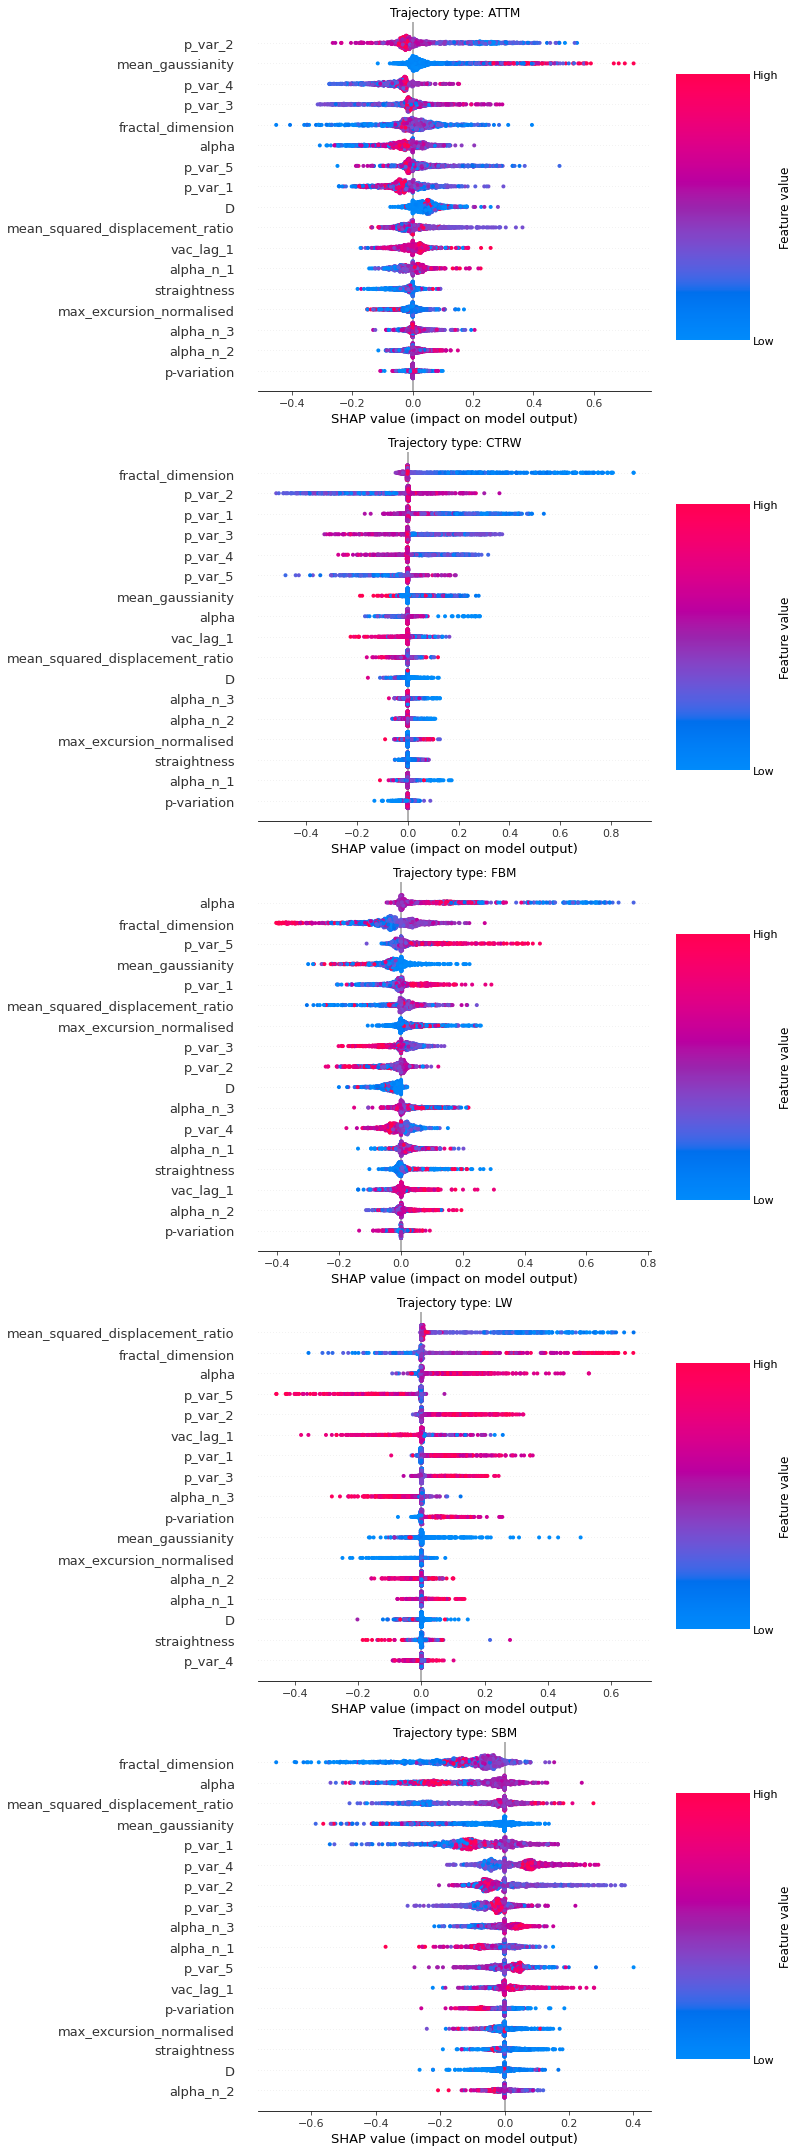

In [102]:
fig, axs = plt.subplots(5, 1)
for i in range(5):
    plt.sca(axs[i])
    shap.summary_plot(shap_coefs[i], x_test_drop.values[:EXPLAIN_OBSERVATION_NO, :], x_test_drop.columns, plot_type='dot', show=False)
    plt.gca().set_title(f"Trajectory type: {CLASS_MAPPING[str(int(model.classes_[i]))]}")
fig.set_size_inches(11, 30)
fig.tight_layout()
plt.savefig(os.path.join('Explanation', 'h', 'SHAP', 'SHAP-dot.pdf'), dpi=500)

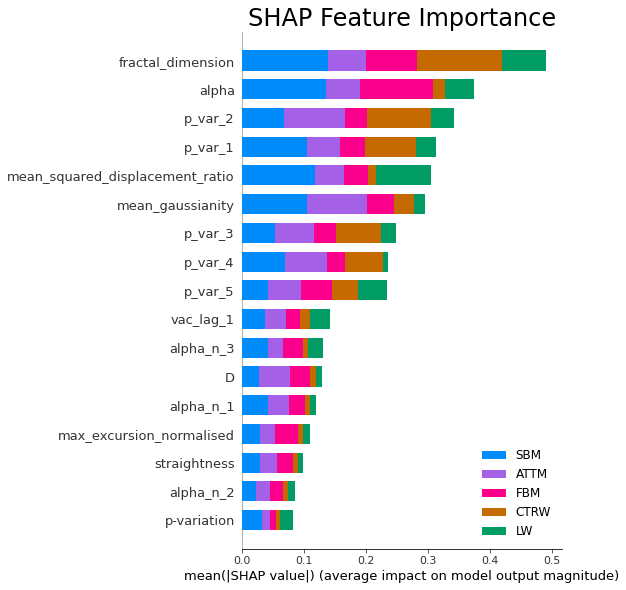

In [103]:
plt.figure()
shap.summary_plot(shap_coefs, x_test_drop.columns, plot_type='bar', class_names=list(CLASS_MAPPING.values()), show=False)
plt.title('SHAP Feature Importance', size=24)
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.savefig(os.path.join('Explanation', 'h', 'SHAP', 'SHAP-FI-all.pdf'), dpi=500)
plt.show()

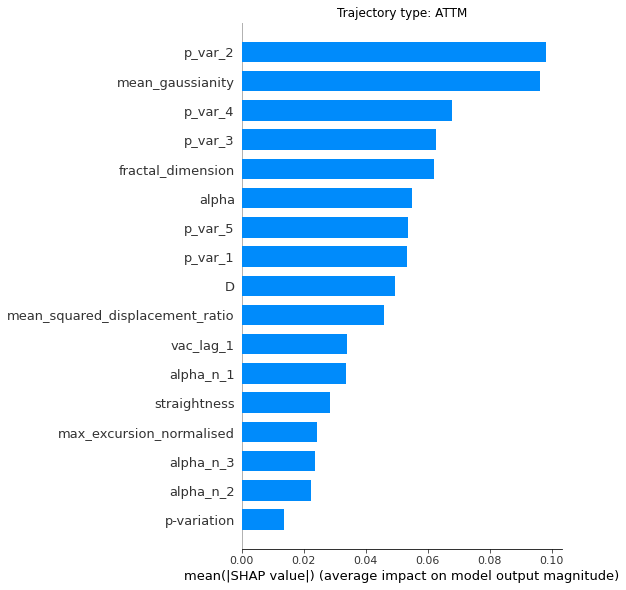

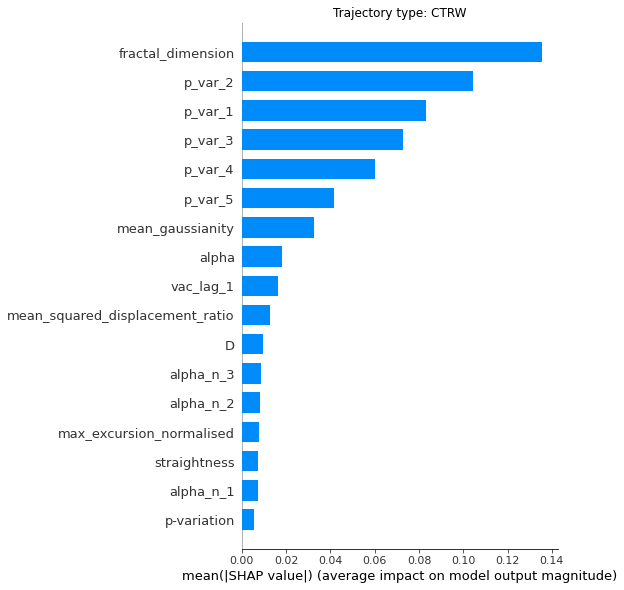

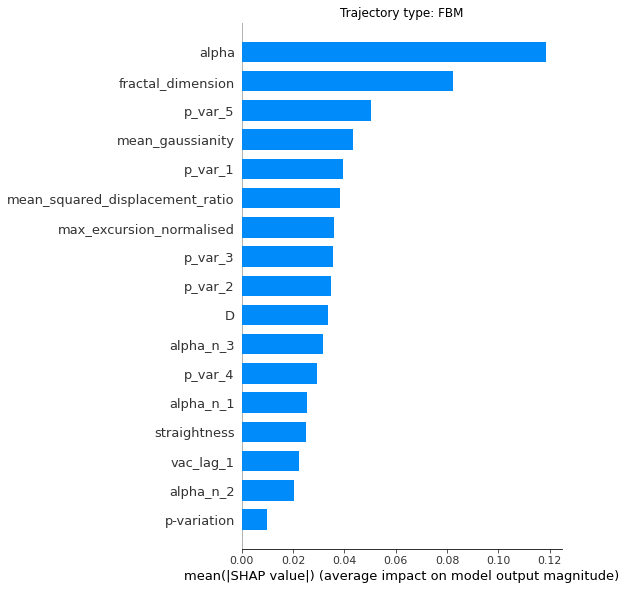

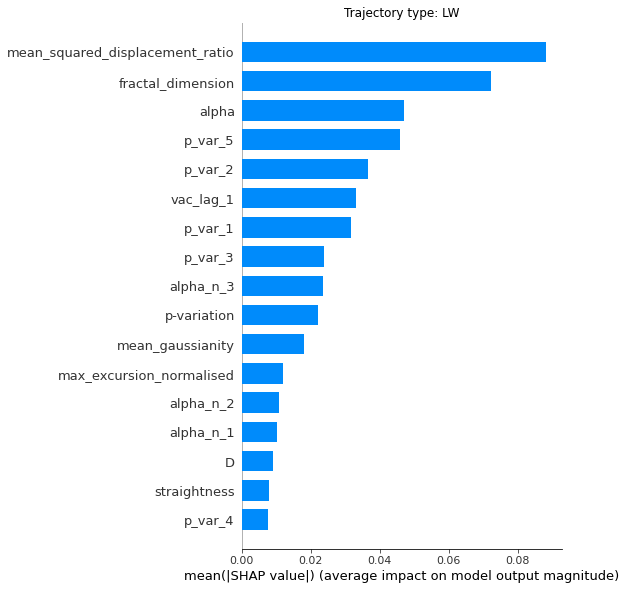

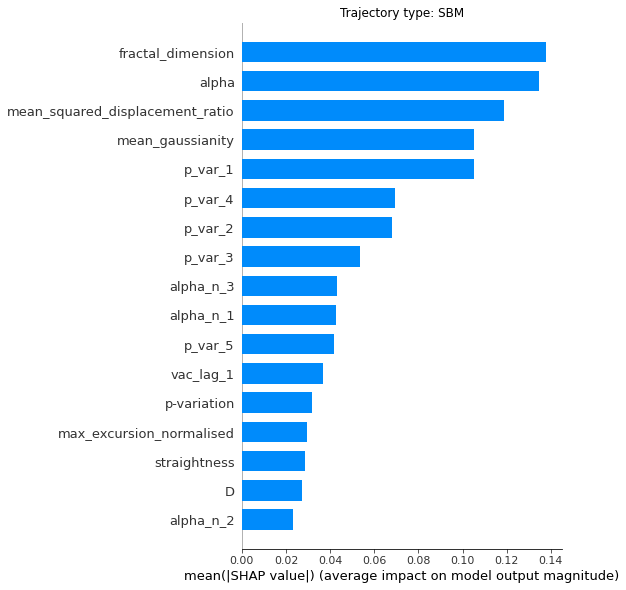

In [104]:
for i in range(5):
    plt.figure()
    shap.summary_plot(shap_coefs[i], x_test_drop.columns, plot_type='bar', show=False)
    plt.title(f"Trajectory type: {CLASS_MAPPING[str(int(model.classes_[i]))]}")
    plt.tight_layout()
    plt.savefig(os.path.join('Explanation', 'h', 'SHAP', f'{CLASS_MAPPING[str(int(model.classes_[i]))]}.pdf'), dpi=400)
    plt.show()

## Create report for chosen observation from the most common mistakes trajectory types

1. BD plot;
2. Variable values vs overall distribution;
3. Ceteris paribus
4. PDP

In [18]:
COMMON_ERRORS = {'True': ['ATTM', 'ATTM', 'FBM'],
                 'Predict': ['CTRW', 'SBM', 'SBM']}

In [19]:
X = pd.read_csv('Data/characteristics/characteristics_h.csv')
X = X.drop(['file', 'Alpha'], axis=1)
X['motion'] = X['motion'].astype(int).astype(str).replace(CLASS_MAPPING)

In [20]:
bd_values = pd.read_csv(os.path.join('Data', 'break-down-values.csv'), index_col=0)

In [21]:
bd_values.iloc[:, -2:] = bd_values.iloc[:, -2:].astype(int).astype(str).replace(CLASS_MAPPING)

In [22]:
def create_observation_vs_distribution(X, observation_bd, class_real, class_pred):
    fig = make_subplots(rows=len(X.columns)-1, cols=1, subplot_titles=list(X.columns[1:]))
    for j, i in enumerate(list(X.columns[1:])):
        X_real = X[X['motion']==class_real]
        X_pred = X[X['motion']==class_pred]
        
        cur_fig = go.Figure()
        cur_fig.add_trace(go.Histogram(x=X_real.loc[:, i],
                                      histnorm='probability density',
                                      name=class_real,                                       
                                      legendgroup=class_real,
                                       showlegend=False if j>0 else True,
                                       marker={'color': 'red'}
                                      ))
        cur_fig.add_trace(go.Histogram(x=X_pred.loc[:, i],
                                      
                                       histnorm='probability density',
                                      name=class_pred,
                                       showlegend=False if j>0 else True,
                                      legendgroup=class_pred,
                                       marker={'color': 'blue'}))
        cur_fig.update_traces(opacity=0.2)
        cur_fig.add_trace(go.Scatter(x=[observation_bd[f'variable_value_{i}']], y=[0],
                                     name='value',
                                     showlegend=False,
                            marker={'color': 'black',
                                   'size':10}))
        cur_fig.update_layout(barmode='overlay')
        
        
        scatter = px.scatter()
        

        fig.add_trace(cur_fig.data[0], row=j+1, col=1)
        fig.add_trace(cur_fig.data[1], row=j+1, col=1)
        fig.add_trace(cur_fig.data[2], row=j+1, col=1)
        fig.update_layout(cur_fig.layout)
        
    fig.update_layout(width=1000, height=6000)
    return fig

In [20]:
for el in list(zip(COMMON_ERRORS['True'], COMMON_ERRORS['Predict'])):
    X_sub = X[(X['motion']==el[0])|(X['motion']==el[1])]
    bd_values_sub = bd_values[(bd_values['real_class']==el[0])&(bd_values['predicted_class']==el[1])].reset_index(drop=True)
    for i, obs in bd_values_sub.iterrows():
        if i<10:
            fig = create_observation_vs_distribution(X, obs, el[0], el[1])
            fig.write_image(os.path.join('Explanation', 'h', 'local', 'observation_vs_variable_distribution', f'{el[0]}_{el[1]}', f'{i+1}.pdf'))


KeyboardInterrupt: 

## Creating report with results

In [23]:
import PyPDF2

In [29]:
def create_local_report(files_in, fileout):
    readers = []
    for file in files_in:
        readers.append(PyPDF2.PdfFileReader(open(file, 'rb')))
#     pdf1File = open(file1, 'rb')
#     pdf2File = open(file2, 'rb')

    # Read the files that you have opened
#     pdf1Reader = PyPDF2.PdfFileReader(pdf1File)
#     pdf2Reader = PyPDF2.PdfFileReader(pdf2File)

    # Create a new PdfFileWriter object which represents a blank PDF document
    pdfWriter = PyPDF2.PdfFileWriter()
    
    for reader in readers:
    # Loop through all the pagenumbers for the first document
        for pageNum in range(reader.numPages):
            pageObj = reader.getPage(pageNum)
            pdfWriter.addPage(pageObj)

    # Now that you have copied all the pages in both the documents, write them into the a new document
    pdfOutputFile = open(fileout, 'wb')
    pdfWriter.write(pdfOutputFile)

    # Close all the files - Created as well as opened
    pdfOutputFile.close()
#     for reader in readers:
#         reader.close()

In [31]:
top_variables = ['fractal_dimension', 'mean_gaussianity', 'p_var_2', 'p_var_3', 'p_var_5']
# top_vars = ['D','alpha','alpha_n_1','alpha_n_2','alpha_n_3','fractal_dimension','mean_gaussianity','mean_squared_displacement_ratio','straightness','p-variation','max_excursion_normalised','vac_lag_1','p_var_1','p_var_2','p_var_3','p_var_4','p_var_5']
for el in list(zip(COMMON_ERRORS['True'], COMMON_ERRORS['Predict'])):
    for i in range(2, 10):
        create_local_report([os.path.join('Explanation', 'h', 'local', 'break_down', f'{el[0]}_{el[1]}', f'{i}.pdf'),
                           os.path.join('Explanation', 'h', 'local', 'observation_vs_variable_distribution', f'{el[0]}_{el[1]}', f'{i}.pdf')]+\
                            [os.path.join('Explanation', 'h', 'local', 'ceteris_paribus', f'{el[0]}_{el[1]}', variable, f'{i}.pdf') for variable in variables]+\
                            [os.path.join('Explanation', 'h', 'local', 'partial_dependency', f'{el[0]}_{el[1]}',  f'{variable}.pdf') for variable in variables],
                           os.path.join('Explanation', 'h', 'local', 'reports', f'{el[0]}_{el[1]}', f'{i}.pdf'))
    

NameError: name 'variables' is not defined